# 소프트맥스 함수
$$ e^z_i \over {e^z_1+e^z_2+e^z_3} $$
$$ z=-ln({1 \over \hat{y}} -1) $$
# 크로스 엔트로피 손실 함수
$$ L=-log(a_{y=1}) $$
$$ {\partial L \over \partial z} = {-(y-a)} $$

In [1]:
# 다중 분류 신경망을 구현합니다.
class MultiClassNetwork:
    def __init__(self, units=10, batch_size=32, leraning_rate=0.1, l1=0, l2=0):
        self.units=units       # 은닉층의 뉴런 개수
        self.w1=None           # 은닉층의 가중치
        self.b1=None           # 은닉층의 절편
        self.w2=None           # 출력층의 가중치
        self.b2=None           # 출력층의 절편
        self.a1=None           # 은닉층의 활성화 출력
        self.losses=[]         # 훈련 손실
        self.val_losses=[]     # 검증 손실
        self.lr=leraning_rate  # 학습률
        self.l1=l1             # L1 손실 하이퍼파라미터
        self.l2=l2             # L2 손실 하이퍼파라미터
        self.batch_size=batch_size    # 배치 크기
    def forpass(self,x):
        z1=np.dot(x, self.w1)+self.b1       # 첫 번째 층의 선형식을 계산합니다.
        self.a1=self.sigmoid(z1)            # 활성화 함수를 적용합니다.
        z2=np.dot(self.a1, self.w2)+self.b2 # 두 번째 층의 선형식을 계산합니다.
        return z2
    def backprop(self, x, err):
        m=len(x)  # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그레디언트를 계산합니다.
        w2_grad=np.dot(self.a1.T, err)/m
        b2_grad=np.sum(err)/m
        # 시그모이드 함수까지 그레디언트를 계산합니다.
        err_to_hidden=np.dot(err,self.w2.T)*self.a1*(1-self.a1)
        # 은닉층의 가중치와 절편에 대한 그레디언트를 계산합니다.
        w1_grad=np.dot(x.T, err_to_hidden)/m
        b1_grad=np.sum(err_to_hidden, axis=0)/m
        return w1_grad, b1_grad, w2_grad, b2_grad
    def sigmoid(self,z):
        a=1/(1+np.exp(-z)) # 시그모이드 계산
        return a
    def softmax(self,z):
        # 소프트맥스 함수
        exp_z=np.exp(z)
        return exp_z/np.sum(exp_z,axis=1).reshape(-1,1)
    def init_weights(self, n_features, n_classes):
        np.random.seed(42)
        self.w1=np.random.normal(0,1,(n_features, self.units)) # (특성 개수, 은닉층의 크기)
        self.b1=np.zeros(self.units)                           # 은닉층의 크기
        self.w2=np.random.normal(0,1,(self.units,n_classes))           # (은닉층의 크기,1)
        self.b2=np.zeros(n_classes)
    # 미니 배치 제너레이터 함수
    def gen_batch(self, x,y):
        length=len(x)
        bins=length//self.batch_size # 미니 배치 횟수
        if length%self.batch_size:
            bins+=1                  # 나누어 떨어지지 않을 때
        indexes=np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x=x[indexes]
        y=y[indexes]
        for i in range(bins):
            start=self.batch_size*i
            end=self.batch_size*(i+1)
            yield x[start:end], y[start:end] # 배치 사이즈만큼 슬라이싱하여 반환합니다.
    def fit(self,x,y,epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1],y.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss=0
            print(',',end='')
            # 제너레이터 함수에서 반환한 미니 배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x,y):
                a=self.training(x_batch,y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a=np.clip(a,1e-10,1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss+=np.sum(-y_batch*np.log(a))
            self.losses.append((loss+self.reg_loss())/len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    def training(self, x, y):
        m=len(x)           # 샘플 개수를 저장합니다.
        z=self.forpass(x)  # 정방향 계산을 수행합니다.
        a=self.softmax(z)  # 활성화 함수를 적용합니다.
        err=-(y-a)             # 오차를 계산합니다.
        # 오차를 역전파하여 그레디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad=self.backprop(x,err)
        # 그레디언트에서 페널티 항의 미분값을 뺍니다.
        w1_grad+=(self.l1*np.sign(self.w1)+self.l2*self.w1)/m
        w2_grad+=(self.l1*np.sign(self.w2)+self.l2*self.w2)/m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1-=self.lr*w1_grad
        self.b1-=self.lr*b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2-=self.lr*w2_grad
        self.b2-=self.lr*b2_grad
        return a
    def predict(self,x):
        z=self.forpass(x)           # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)# 가장 큰 값의 인덱스를 반환합니다.
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x)==np.argmax(y,axis=1))
    def update_val_loss(self, x_val,y_val):
        z=self.forpass(x_val)      #정방향 계산을 수행합니다.
        a=self.softmax(z)          # 활성화 함수를 적용합니다.
        a=np.clip(a,1e-10,1-1e-10) # 출력값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss=np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss+self.reg_loss())/len(y_val))
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1*np.sum(np.abs(self.w1))+np.sum(np.abs(self.w2))+\
                self.l2/2*(np.sum(self.w1**2)+np.sum(self.w2**2))

In [2]:
# 의류 데이터를 준비합니다.
import tensorflow as tf
tf.__version__

'2.4.0'

In [3]:
(x_train_all, y_train_all),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


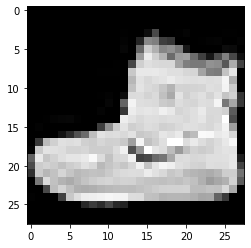

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0],cmap='gray')
plt.show()

In [6]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [7]:
class_names=['티셔츠/윗도리','바지','스웨터','드레스','코트','샌들','셔츠','스니커즈','가방','앵클부츠']

In [8]:
print(class_names[y_train_all[0]])

앵클부츠


In [9]:
import numpy as np
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [11]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [12]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [13]:
x_train=x_train/255
x_val=x_val/255

In [14]:
x_train=x_train.reshape(-1,784)
x_val=x_val.reshape(-1,784)

In [15]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [16]:
# 타깃 데이터를 준비하고 다중 분류 신경망을 훈련합니다.
tf.keras.utils.to_categorical([0,1,3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [17]:
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [18]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [19]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [20]:
fc=MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

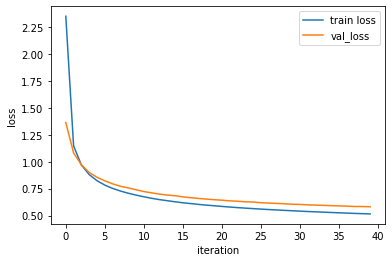

In [22]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train loss','val_loss'])
plt.show()

In [23]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [ ]:
# 케라스에 대해 알아봅니다.
# 훈련할 가중치 변수를 선언합니다.
w=tf.Variable(tf.zeros(shape=(1)))
b=tf.Variable(tf.zeros(shape=(1)))

# 경사 하강법 옵티마이저를 설정합니다.
optimizer=tf.optimizers.SGD(lr=0.01)
# 에포크 횟수만큼 훈련합니다.
num_epochs=10
for step in range(num_epochs):
  # 자동 미분을 위해 연산 과정을 기록합니다.
  with tf.GradientTape() as tape:
    z_net=w*x_train+b
    print(z_net)
    z_net=tf.reshape(z_net, [-1])
    sqr_errors=tf.square(y_train-z_net)
    mean_cost=tf.reduce_mean(sqr_errors)
  # 손실 함수에 대한 가중치의 그레디언트를 계산합니다.
  grads=tape.gradient(mean_cost, [w,b])
  # 옵티마이저에 그레디언트를 반영합니다.
  optimizer.apply_gradients(zip(grads,[w,b]))

In [29]:
# 신경망 모델을 만듭니다.
model = tf.keras.models.Sequential()
# 완전 연결층을 추가합니다.
model.add(tf.keras.layers.Dense(1))
# 옵티마이저와 손실 함수를 지정합니다.
model.compile(optimizer='sgd',loss='mse')
# 훈련 데이터를 사용하여 에포크 횟수만큼 훈련합니다.
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 2s 824us/step - loss: nan
Epoch 2/10
1500/1500 [==============================] - 1s 827us/step - loss: nan
Epoch 3/10
1500/1500 [==============================] - 1s 870us/step - loss: nan
Epoch 4/10
1500/1500 [==============================] - 1s 852us/step - loss: nan
Epoch 5/10
1500/1500 [==============================] - 1s 851us/step - loss: nan
Epoch 6/10
1500/1500 [==============================] - 1s 886us/step - loss: nan
Epoch 7/10
1500/1500 [==============================] - 1s 886us/step - loss: nan
Epoch 8/10
1500/1500 [==============================] - 1s 833us/step - loss: nan
Epoch 9/10
1500/1500 [==============================] - 1s 829us/step - loss: nan
Epoch 10/10
1500/1500 [==============================] - 1s 874us/step - loss: nan


In [31]:
# 케라스로 다중 분류 신경망을 만들어봅니다.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model=Sequential()

In [32]:
model.add(Dense(100,activation='sigmoid',input_shape=(784,)))
model.add(Dense(10,activation='softmax'))

In [33]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
history=model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 3s 2ms/step - loss: 1.7110 - accuracy: 0.5401 - val_loss: 0.9468 - val_accuracy: 0.7315
Epoch 2/40
1500/1500 [==============================] - 2s 2ms/step - loss: 0.8869 - accuracy: 0.7352 - val_loss: 0.7430 - val_accuracy: 0.7633
Epoch 3/40
1500/1500 [==============================] - 2s 2ms/step - loss: 0.7295 - accuracy: 0.7608 - val_loss: 0.6583 - val_accuracy: 0.7774
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6514 - accuracy: 0.7772 - val_loss: 0.6088 - val_accuracy: 0.7919
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6024 - accuracy: 0.7943 - val_loss: 0.5733 - val_accuracy: 0.8031
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5733 - accuracy: 0.8041 - val_loss: 0.5476 - val_accuracy: 0.8122
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5571 - accuracy: 0.8075 - val_loss: 0.5281 - val_accuracy:

In [36]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


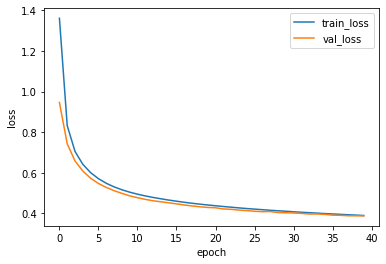

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

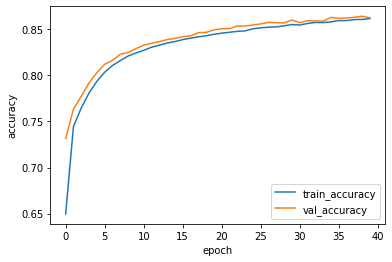

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [39]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.862583339214325
